In [9]:
import pandas as pd
import numpy as np
import time
import rebound

## Simulate Systems

In [230]:
#get masses, spacing, etc. from previous run
df = pd.read_csv('../data/1e7datasetcorr.csv', index_col=0)
df.head()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,Omega3,f3,x3,y3,z3,vx3,vy3,vz3,Rel_Eerr,integ_time
Sim_ID,,,,,,,,,,,,,,,,,,,,,
0,True,1.000000e+07,10000000.0,0.000015,0.021544,0.056888,0.013569,0.005178,-3.070751,0.007067,...,-0.567081,-0.108162,-0.060508,-0.044636,-0.000307,13.734230,-18.555393,-0.036173,2.044850e-10,2039.672515
1,True,1.000000e+07,10000000.0,0.000015,0.021544,0.042687,0.008820,0.005101,-3.170275,0.007845,...,1.437355,-0.343874,-0.045725,0.037512,0.000634,-16.384604,-19.975136,0.171042,3.447072e-09,1894.023723
2,True,1.000000e+07,10000000.0,0.000015,0.021544,0.059121,0.014375,0.001697,-1.033591,0.012845,...,-0.317958,3.419165,-0.008500,0.078357,0.001246,-22.158744,-2.450004,-0.160703,3.936231e-09,2163.505740
3,False,1.118280e+06,10000000.0,0.000015,0.021544,0.044759,0.009469,0.012078,-2.351669,0.001144,...,-2.294238,-0.829096,-0.058453,-0.002614,-0.000111,1.345952,-26.024377,0.047938,1.089428e-06,248.877695
4,False,2.045246e+05,10000000.0,0.000015,0.021544,0.044721,0.009457,0.003099,0.417927,0.007009,...,-1.074927,-1.214839,0.056472,0.007511,0.000862,-3.526080,26.095055,0.150793,5.464036e-07,46.893125


In [231]:
def system(sim_id, maxorbs, Noutputs):
    s = df.loc[sim_id]
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.G = 4*np.pi**2
    mp = s['Mplanet']
    gamma = s['RH/a']
    for i in ['1', '2', '3']:
        sim.add(m=mp, x=s['x'+i], y=s['y'+i], z=s['z'+i], vx=s['vx'+i], vy=s['vy'+i], vz=s['vz'+i])
    sim.move_to_com()
    ps = sim.particles

    sim.integrator="whfast"
    P0 = ps[1].P
    tmax = maxorbs * P0 # number of inner planet orbital periods to integrate
    sim.dt = P0*0.09
    sim.exit_min_distance = ps[1].a*gamma # use smaller hill radius as exit condition

    sim.init_megno()

    features = [maxorbs, mp, gamma]
    for p in ps[1:sim.N_real]:
        features = features + [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f]

    stable = [True] # assume it's stable and update if not

    E0 = sim.calculate_energy()
    t0 = time.time()

    times = np.linspace(0,tmax,Noutputs)
    outputs = '../data/FeaturesFromShortRuns/output%d_maxorbs%.1e_Noutputs%.1e.csv'%(sim_id,maxorbs,Noutputs)
    #outputs = '/mnt/raid-cita/dtamayo/Stability/data/featuresfromshortruns/output'+str(sim_id)+'.csv'

    with open(outputs, 'w') as f:
        try:
            for t in times:
                sim.integrate(t)
                f.write(str(sim.t))
                try:
                    outs = [1./sim.calculate_lyapunov()]
                except: 
                    outs = [np.inf]
                for p in ps[1:sim.N_real]:
                    outs = outs + [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f]

                for out in outs:
                    f.write(',{0}'.format(out))
                f.write('\n')
        except rebound.Encounter as error:
            stable = [False]
            f.write(str(sim.t)) # this block added after the 1e7 dataset was generated for future use
            try:
                outs = [1./sim.calculate_lyapunov()]
            except: 
                outs = [np.inf]
            for p in ps[1:sim.N_real]:
                outs = outs + [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f]

            for out in outs:
                f.write(',{0}'.format(out))
            f.write('\n')

    features = [sim_id] + stable+[sim.t/P0]+features+[np.abs((sim.calculate_energy()-E0)/E0), time.time()-t0]
    return features

In [179]:
#input parameters
maxorbs = 2.e5
Noutputs = 5e4

**Warning!** This could take a minute.

In [233]:
for sim_id in range(1):
    f = system(sim_id,maxorbs,Noutputs)

## Analyze Systems

In [240]:
sim_id = 9
columns = ['Time', 'Lyapunov Time']
for i in ['1', '2', '3']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]
            
filename = '../data/FeaturesFromShortRuns/output%d_maxorbs%.1e_Noutputs%.1e.csv'%(sim_id,maxorbs,Noutputs)

run = pd.read_csv(filename, names=columns)
run.tail()

,Time,Lyapunov Time,a1,P1,e1,pomega1,inc1,Omega1,f1,a2,...,inc2,Omega2,f2,a3,P3,e3,pomega3,inc3,Omega3,f3
12168,532.089105,NaN,0.048475,0.010673,0.028333,-4.342532,0.002282,-2.879394,1.707601,0.055861,...,0.007080,-0.734290,1.700250,0.064590,0.016415,0.063381,2.996233,0.004558,0.878685,-2.096354
12169,532.132833,NaN,0.048242,0.010596,0.029573,-4.078888,0.002217,-2.966376,2.070795,0.056157,...,0.007174,-0.756407,-2.867140,0.064608,0.016422,0.063877,2.995168,0.004557,0.878223,-3.998973
12170,532.176562,NaN,0.048239,0.010595,0.030221,-4.060165,0.002200,-2.985064,2.811956,0.056150,...,0.007188,-0.762691,-1.139933,0.064637,0.016433,0.064315,2.982170,0.004564,0.876517,0.085327
12171,532.220291,NaN,0.048150,0.010566,0.031355,-4.016338,0.002196,-2.992936,3.587849,0.056271,...,0.007187,-0.764615,0.834349,0.064627,0.016429,0.064018,2.980308,0.004564,0.875776,-2.159810
12172,532.226194,NaN,0.048171,0.010572,0.031773,-4.019296,0.002196,-2.993369,0.893930,0.055272,...,0.005438,-1.020004,-2.827275,0.066095,0.016992,0.085093,2.961670,0.005961,0.548859,0.259535


In [241]:
#1-D frequency map
import scipy.signal as signal
#extra variables that we might want to plot
def get_var(data,i,var):
    if var == "LT":
        LT = data["Lyapunov Time"]
        LT[0] = 0
        return LT
    if var == "z":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.exp(pomega*1j)
    if var == "h":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.cos(pomega)
    if var == "k":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.sin(pomega)
    else:
        return data[var+i].values

def fourier(data,var,output_name):
    fig, ax = plt.subplots(2, figsize=(8,6))
    t=data["Time"].values
    tmax = round(t[-1])
    N_outputs = len(t)
    window = np.hanning(N_outputs)
    Period = 1./np.fft.fftfreq(N_outputs, tmax/N_outputs)   
    power_ratio = 0                                 #ratio of power[OP1>boundaryOP1]/power[OP1<boundaryOP1]
    names = ['Planet 1','Planet 2','Planet 3']
    for i,num in enumerate(['1','2','3']):
        y = get_var(data,num,var)
        power = np.absolute(np.fft.fft(y)/N_outputs)
        OP1 = Period/data["P1"][0]                 #normalize to orbital period of inner planet
        len(power), len(OP1)
        power = power[(OP1>0)&(OP1<float('inf'))]
        OP1 = OP1[(OP1>0)&(OP1<float('inf'))]
        boundaryOP1 = 10**(max(np.log10(OP1))/2)   #boundary is even split in log space
        power_ratio += sum(power[OP1>=boundaryOP1])/sum(power[OP1<boundaryOP1])
        ax[0].plot(OP1,power,label=names[i],alpha=1-0.2*i)
        ax[1].plot(t,y,label=num,alpha=1-0.2*i)

    plt.subplots_adjust(hspace=0.4)
    ax[0].set_ylabel("power of: "+var, fontsize=13)
    ax[0].set_xlabel('Orbital Period of Planet 1', fontsize=13)
    ax[0].set_xscale('log')
    #ax[0].set_ylim([0,5e-4])
    ax[1].set_ylabel(var, fontsize=13)
    ax[1].set_xlabel('time', fontsize=13)
    plt.show()
    #plt.savefig(output_name.split(".csv")[0]+"-fft_var"+var+".png")
    #plt.clf()
    
    print("For variable:'%s', The ratio of Power[Period>=%.1e]/[Period<%.1e]=%f"%(var,boundaryOP1,boundaryOP1,power_ratio))
    return power_ratio

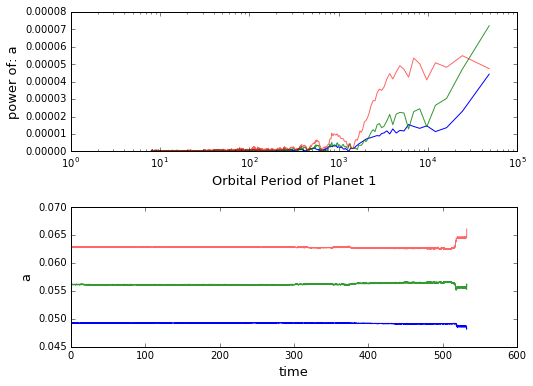

For variable:'a', The ratio of Power[Period>=2.2e+02]/[Period<2.2e+02]=1.832628


In [242]:
power_ratio = fourier(run,"a",filename)

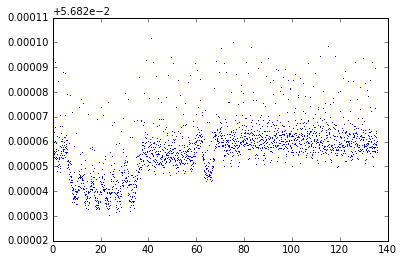

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(run['Time'], run['a1'], ',')
#ax.set_xlim([0,20])

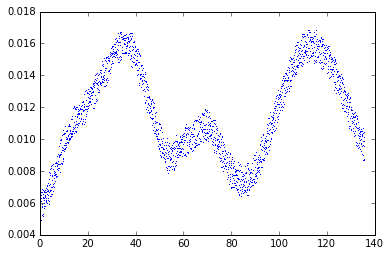

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(run['Time'], run['e1'], ',')
#ax.set_xlim([0,20])

(0, 20)

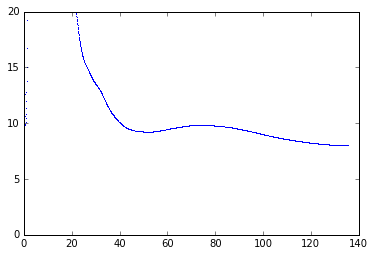

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(run['Time'], run['Lyapunov Time'], ',')
ax.set_ylim([0, 20])

In [23]:
df['Pratio21'] = df['P2']/df['P1']
df['Pratio32'] = df['P3']/df['P2']
dfnonres = df.loc[(df['Pratio21'] > 1.269) & (df['Pratio21'] < 1.271)]
simnonresids = dfnonres.index.values